In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/memory/"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [24]:
mer.head()

,sequence,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus,Comparison,Age,Sex,tax,OTU
0,TACGGAGGGGGCGAGCGTTGTTCGGAGTGACTGGGCGTAAAGAGCA...,324.922368,2.737734,0.770521,3.553096,3.807250e-04,1.950158e-02,Bacteria,Deferribacteres,Deferribacteres,Deferribacterales,Deferribacteraceae,Mucispirillum,ControlRapaEarly,Mid,F,Bacteria_Deferribacteres_Deferribacteres_Defer...,ASV_38
1,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,146.053101,-10.759683,2.585369,-4.161759,3.158059e-05,2.384571e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ControlRapaEarly,Mid,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_46
2,GACAGAGGATGCAAGCGTTATCCGGAATGATTGGGCGTAAAGCGTC...,7.001228,-22.868945,2.935271,-7.791084,6.643680e-15,2.100857e-12,Bacteria,Cyanobacteria,Oxyphotobacteria,Chloroplast,NaN,NaN,ControlRapaEarly,Mid,F,Bacteria_Cyanobacteria_Oxyphotobacteria_Chloro...,ASV_103
3,TACGTAGGTGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTG...,233.430621,-5.569361,1.196494,-4.654734,3.243997e-06,3.738706e-04,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Faecalibaculum,ControlRapaEarly,Mid,F,Bacteria_Firmicutes_Erysipelotrichia_Erysipelo...,ASV_126
4,TACGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGAG...,44.923934,-3.195846,0.773732,-4.130432,3.620823e-05,2.384571e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4A136_group,ControlRapaEarly,Mid,F,Bacteria_Firmicutes_Clostridia_Clostridiales_L...,ASV_163


In [38]:
al = mer[mer["Sex"] == "ALL"]

x = al[al["Age"] == "Mid"]
contRA_mid = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = al[al["Age"] == "Mid"]
contRE_mid = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]
x = al[al["Age"] == "Young"]
contRA_young = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]

x = al[al["Age"] == "Old"]
contRA_old = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = al[al["Age"] == "Old"]
contRE_old = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]

x = al[al["Age"] == "Old"]
contRL_old = x[x["Comparison"] == "ControlRapaLate"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_27599/1243238811.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


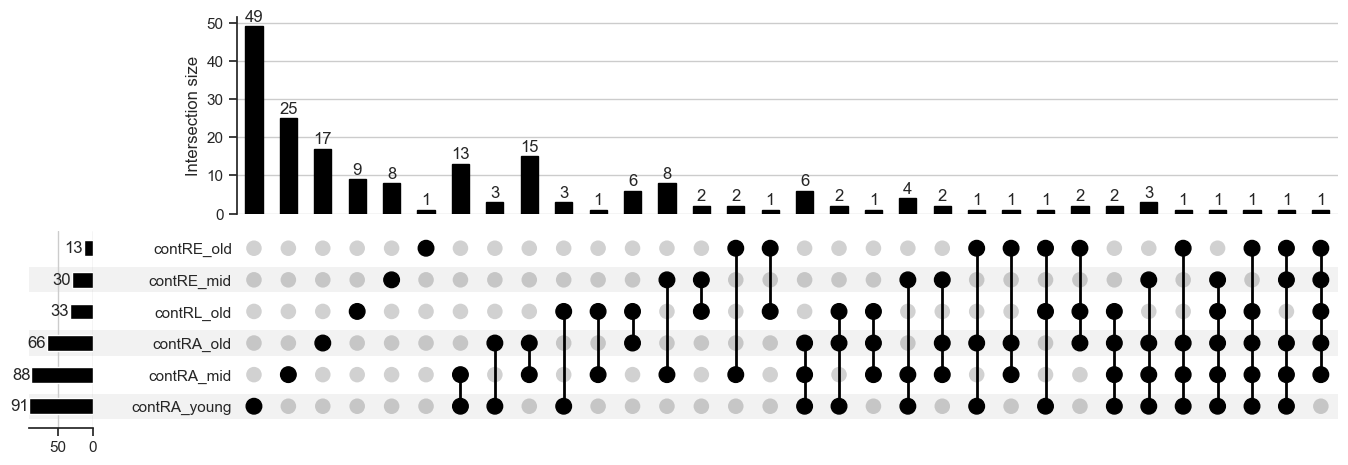

In [39]:
from upsetplot import from_contents
from upsetplot import UpSet
changes = from_contents(
    {"contRA_mid":contRA_mid.unique(), "contRE_mid":contRE_mid.unique(), "contRA_young":contRA_young.unique(),
     "contRA_old":contRA_old.unique(), "contRE_old":contRE_old.unique(), "contRL_old":contRL_old.unique()}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("../analysis/plots/memory/all.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_18239/1091670969.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


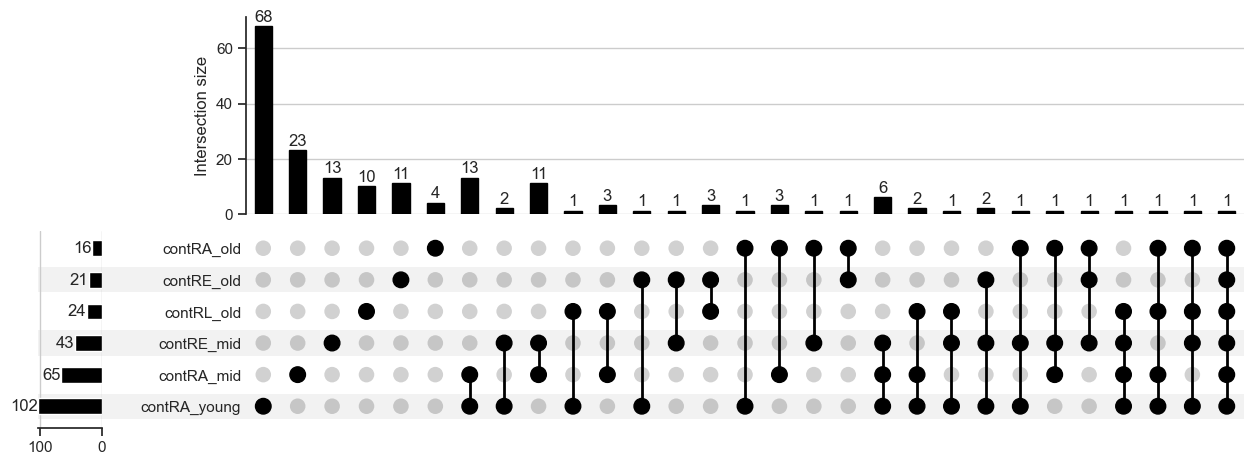

In [20]:
# males
males = mer[mer["Sex"] == "M"]
x = males[males["Age"] == "Mid"]
contRA_mid = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = males[males["Age"] == "Mid"]
contRE_mid = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]
x = males[males["Age"] == "Young"]
contRA_young = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]

x = males[males["Age"] == "Old"]
contRA_old = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = males[males["Age"] == "Old"]
contRE_old = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]

x = males[males["Age"] == "Old"]
contRL_old = x[x["Comparison"] == "ControlRapaLate"]["OTU"]

changes = from_contents(
    {"contRA_mid":contRA_mid.unique(), "contRE_mid":contRE_mid.unique(), "contRA_young":contRA_young.unique(),
     "contRA_old":contRA_old.unique(), "contRE_old":contRE_old.unique(), "contRL_old":contRL_old.unique()}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("../analysis/plots/memory/males_all.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_18239/3157307152.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


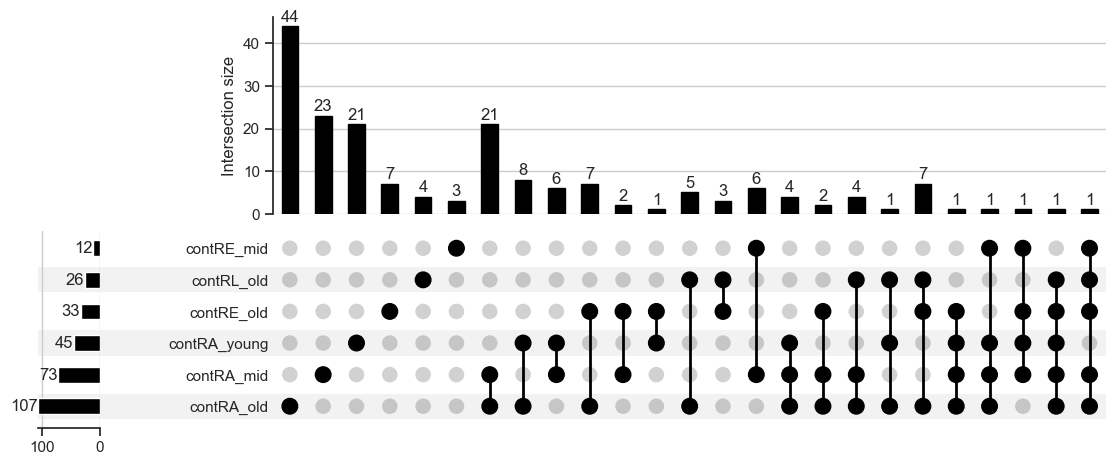

In [19]:
# females

males = mer[mer["Sex"] == "F"]
x = males[males["Age"] == "Mid"]
contRA_mid = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = males[males["Age"] == "Mid"]
contRE_mid = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]
x = males[males["Age"] == "Young"]
contRA_young = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]

x = males[males["Age"] == "Old"]
contRA_old = x[x["Comparison"] == "ControlRapaAdult"]["OTU"]
x = males[males["Age"] == "Old"]
contRE_old = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]

x = males[males["Age"] == "Old"]
contRL_old = x[x["Comparison"] == "ControlRapaLate"]["OTU"]

changes = from_contents(
    {"contRA_mid":contRA_mid.unique(), "contRE_mid":contRE_mid.unique(), "contRA_young":contRA_young.unique(),
     "contRA_old":contRA_old.unique(), "contRE_old":contRE_old.unique(), "contRL_old":contRL_old.unique()}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("../analysis/plots/memory/females_all.pdf")

In [40]:
x = al[al["Age"] == "Mid"]
contRE_mid = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]
x = al[al["Age"] == "Old"]
contRE_old = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]

x = al[al["Age"] == "Old"]
contRL_old = x[x["Comparison"] == "ControlRapaLate"]["OTU"]

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_27599/1060310656.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


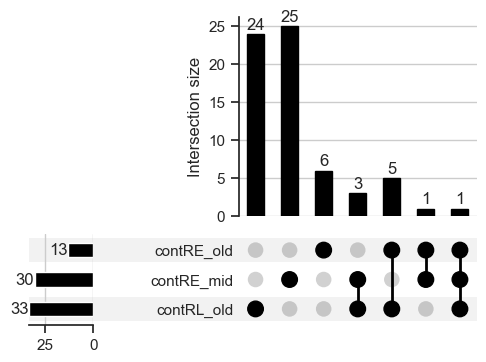

In [41]:
from upsetplot import from_contents
from upsetplot import UpSet
changes = from_contents(
    {"contRE_mid":contRE_mid.unique(), "contRE_old":contRE_old.unique(),
    "contRL_old":contRL_old.unique()}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("../analysis/plots/memory/all_RARE.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_27599/4072820723.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


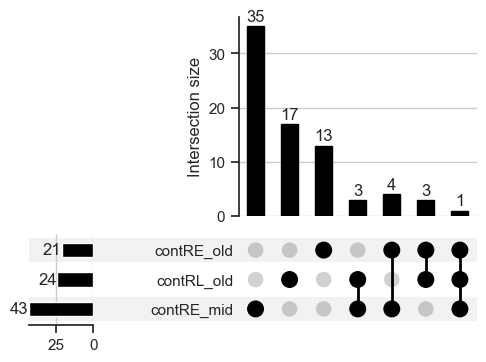

In [16]:
males = mer[mer["Sex"] == "M"]
x = males[males["Age"] == "Mid"]
contRE_mid = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]
x = males[males["Age"] == "Old"]
contRE_old = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]

x = males[males["Age"] == "Old"]
contRL_old = x[x["Comparison"] == "ControlRapaLate"]["OTU"]

changes = from_contents(
    {"contRE_mid":contRE_mid.unique(), "contRE_old":contRE_old.unique(),
    "contRL_old":contRL_old.unique()}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("../analysis/plots/memory/males_RARE.pdf")

/var/folders/1d/m_275l6153b26smzn9vx6txh0000gp/T/ipykernel_27599/216911737.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


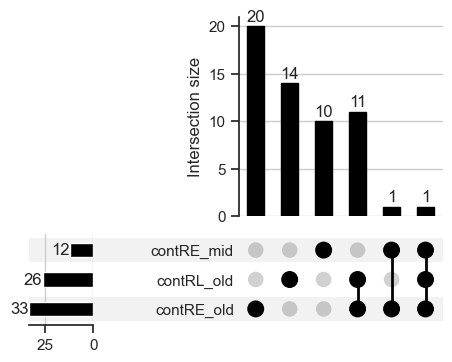

In [15]:
#Females
males = mer[mer["Sex"] == "F"]
x = males[males["Age"] == "Mid"]
contRE_mid = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]
x = males[males["Age"] == "Old"]
contRE_old = x[x["Comparison"] == "ControlRapaEarly"]["OTU"]

x = males[males["Age"] == "Old"]
contRL_old = x[x["Comparison"] == "ControlRapaLate"]["OTU"]

changes = from_contents(
    {"contRE_mid":contRE_mid.unique(), "contRE_old":contRE_old.unique(),
    "contRL_old":contRL_old.unique()}
)

ax_dict = UpSet(changes, subset_size="count", show_counts=True).plot()
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig("../analysis/plots/memory/females_RARE.pdf")

In [21]:
# Yuxuans question
old = mer[mer["Age"] == "Old"]
a = old[old["Sex"] == "ALL"]
m = old[old["Sex"] == "M"]
f = old[old["Sex"] == "F"]

In [36]:
#1.	(male and female pooled) ConRA old vs ConRE old (27/128, 21%):

a[a["Comparison"].isin(["ControlRapaLate", "ControlRapaEarly", "ControlRapaAdult"])]["Comparison"].value_counts()

ControlRapaAdult    66
ControlRapaLate     33
ControlRapaEarly    13
Name: Comparison, dtype: int64